In [2]:
import joblib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import load_model

from loss_functions import correlated_gaussian_loss
from proper_scoring_rule import calculate_negative_log_likelihood, calculate_negative_log_likelihood_multi_gaussian, \
    energy_scores_for_multiple_ys_and_gaussians
from utilities import prepare_covariance_matrix, compute_conditional_stats

plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10

# import data
day_ahead_features_test = pd.read_pickle(r"../data_DE/day_ahead_features_test.pkl").dropna()
frequency_test = pd.read_pickle(r"../data_DE/frequency_test.pkl").dropna()

# Ensure day_ahead_features_test and frequency_test have the same datetime index
common_index = day_ahead_features_test.index.intersection(frequency_test.index)
day_ahead_features_test = day_ahead_features_test.loc[common_index]
day_ahead_features_test = day_ahead_features_test[~day_ahead_features_test.index.duplicated(keep='first')]  # drop duplicates
frequency_test = frequency_test.loc[common_index]

day_ahead_features_test_np = day_ahead_features_test.to_numpy()
frequency_test_np = frequency_test.to_numpy()
inputs_test = day_ahead_features_test_np
scaler = joblib.load(f"../trained_models/scaler.gz")
inputs_test = scaler.transform(inputs_test)

# Frequency Deviation
outputs_test = frequency_test_np - 50.0

# load sequence models
aggregation = 15
N = 3600 // aggregation
covariance_matrix_eq = prepare_covariance_matrix(N, kernel_type='ExponentiatedQuadratic')
covariance_matrix_rq = prepare_covariance_matrix(N, kernel_type='RationalQuadratic')
loss_eq = {"loss": correlated_gaussian_loss(N, covariance_matrix_eq)}
loss_rq = {"loss": correlated_gaussian_loss(N, covariance_matrix_rq)}

# standard with transformer
model_rational_quadratic = load_model(f"../trained_models/correlated_gaussian_rational_quadratic",
                                      custom_objects=loss_rq)
model_exponentiated_quadratic = load_model(f"../trained_models/correlated_gaussian_Exponentiated_Quadratic",
                                           custom_objects=loss_eq)

# model_rational_quadratic = load_model(f"trained_models/correlated_gaussian_rational_quadratic_GRU",
#                                       custom_objects=loss_rq)
# model_exponentiated_quadratic = load_model(f"trained_models/correlated_gaussian_Exponentiated_Quadratic_GRU",
#                                            custom_objects=loss_eq)
model_transformer_gaussian = load_model(f"../trained_models/transformer_gaussian_15s")

outputs_test_angular_frequency = outputs_test.astype(np.float32) * (2 * np.pi)

outputs_test_angular_frequency = outputs_test_angular_frequency[:, ::aggregation]

predictions_rational_quadratic = model_rational_quadratic.predict(inputs_test)
predictions_exponentiated_quadratic = model_exponentiated_quadratic.predict(inputs_test)

mu_rational_quadratic = 2 * np.pi * predictions_rational_quadratic[:, :N]
mu_exponentiated_quadratic = 2 * np.pi * predictions_exponentiated_quadratic[:, :N]

sigma2_rational_quadratic = (2 * np.pi) ** 2 * tf.math.sigmoid(predictions_rational_quadratic[:, N:])
sigma2_rational_quadratic = np.array(sigma2_rational_quadratic).reshape(-1, 1, 1)
sigma2_rational_quadratic = np.array(sigma2_rational_quadratic) * covariance_matrix_rq

sigma2_exponentiated_quadratic = (2 * np.pi) ** 2 * tf.math.sigmoid(predictions_exponentiated_quadratic[:, N:])
sigma2_exponentiated_quadratic = np.array(sigma2_exponentiated_quadratic).reshape(-1, 1, 1)
sigma2_exponentiated_quadratic = np.array(sigma2_exponentiated_quadratic) * covariance_matrix_eq

predictions_test_transformer = model_transformer_gaussian.predict(inputs_test)
mu_test_transformer = 2 * np.pi * predictions_test_transformer[:, :240]
sigma_test_transformer = 2 * np.pi * tf.math.softplus(predictions_test_transformer[:, 240:])

squared_sigmas = sigma_test_transformer ** 2
cov_matrices = np.zeros(
    (sigma_test_transformer.shape[0], sigma_test_transformer.shape[1], sigma_test_transformer.shape[1]))
np.einsum('ij,jk->ijk', squared_sigmas, np.eye(sigma_test_transformer.shape[1]), out=cov_matrices)

2024-10-13 22:19:05.924013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-13 22:19:05.924050: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/qnlzgl/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
2024-10-13 22:19:09.485576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have be

245/245 [==============================] - 2s 5ms/step


array([[[0.00081414, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.00421682, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.00690413, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.0099939 ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.0105542 , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.01113544]],

       [[0.00066442, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.00377471, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.00611655, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00869354,
         0.        , 0.        ],
        [0. 

In [25]:
mu_rational_quadratic.mean(axis=1).shape

(7832,)

In [23]:
# Calculate MSE of the predictions
mse_rational_quadratic = np.mean(np.square(mu_rational_quadratic.mean(axis=1)/ (2*np.pi) - outputs_test_angular_frequency.mean(axis=1)/ (2*np.pi))) ** 0.5
mse_exponentiated_quadratic = np.mean(np.square(mu_exponentiated_quadratic.mean(axis=1)/ (2*np.pi) - outputs_test_angular_frequency.mean(axis=1)/ (2*np.pi)))** 0.5
mse_transformer = np.mean(np.square(mu_test_transformer.mean(axis=1)/ (2*np.pi) - outputs_test_angular_frequency.mean(axis=1)/ (2*np.pi)))** 0.5

print(f"MSE Rational Quadratic: {mse_rational_quadratic}")
print(f"MSE Exponentiated Quadratic: {mse_exponentiated_quadratic}")
print(f"MSE Transformer: {mse_transformer}")

MSE Rational Quadratic: 0.008478451092133263
MSE Exponentiated Quadratic: 0.008557405889057975
MSE Transformer: 0.010080365854907397


<Axes: >

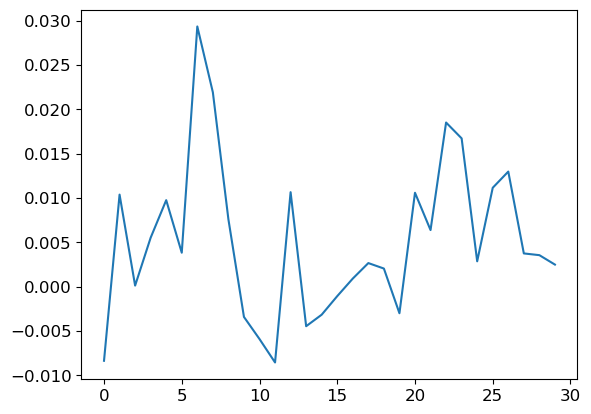

In [22]:
pd.Series(outputs_test_angular_frequency.mean(axis=1) / (2*np.pi)).head(30).plot()

1/1 [==============================] - 0s 15ms/step


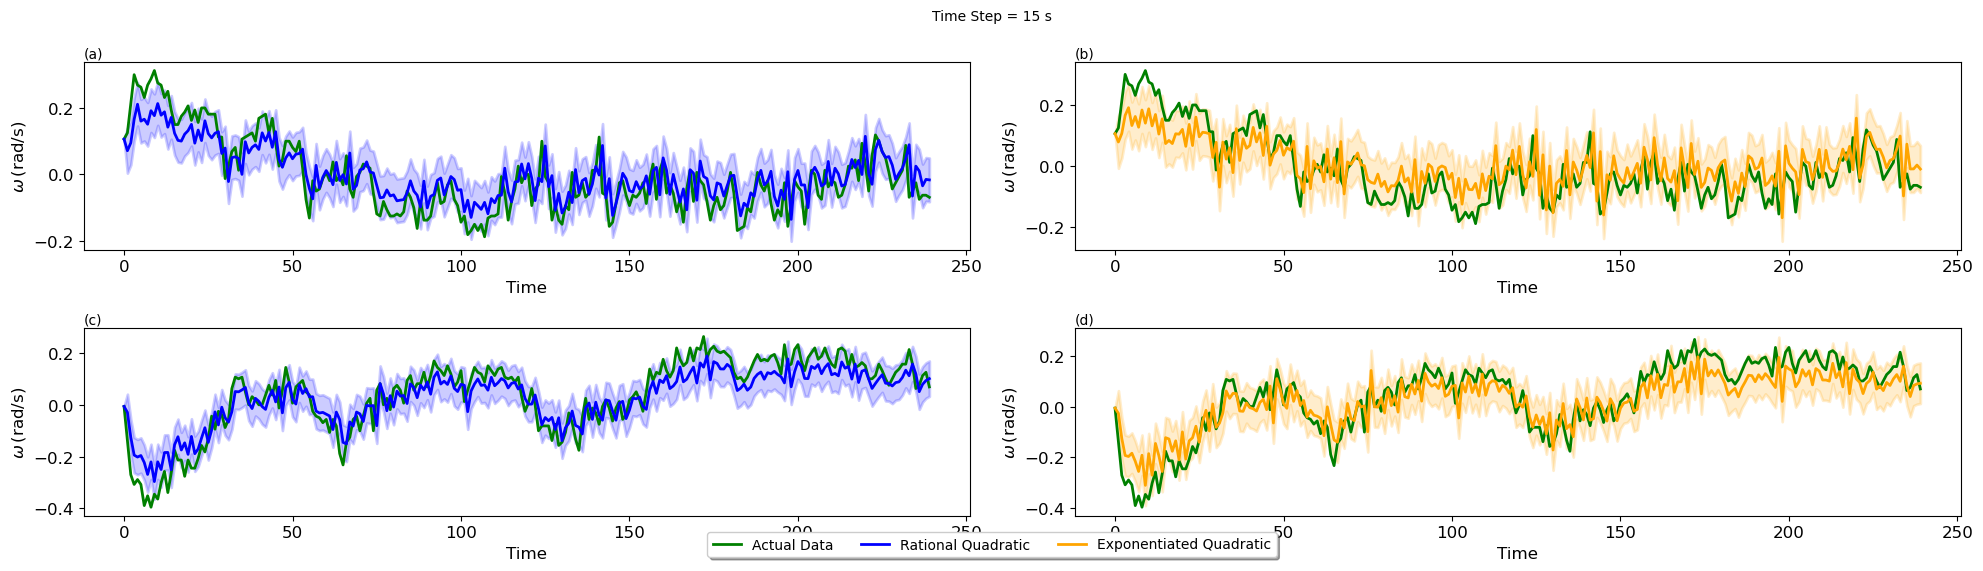

In [94]:
import random

def get_prediction_sample_times():
    return [
        # day_ahead_features_test.index.get_loc('2019-11-20 02:00:00'),
        # day_ahead_features_test.index.get_loc('2019-04-07 13:00:00'),
        day_ahead_features_test.index.get_loc('2019-09-05 05:00:00'),
        # day_ahead_features_test.index.get_loc('2019-03-06 01:00:00'),
        # day_ahead_features_test.index.get_loc('2019-08-30 23:00:00')
        day_ahead_features_test.index.get_loc('2019-03-06 19:00:00')
    ]

def get_feature_and_true_output(position):
    len_outputs = outputs_test_angular_frequency.shape[1]  # Define len_outputs
    feature_input = inputs_test[position, :].reshape(1, 14)
    true_output = outputs_test_angular_frequency[position, :].reshape(len_outputs, 1)
    return feature_input, true_output

def get_predictions(feature_input):
    prediction_rational_quadratic = model_rational_quadratic.predict(feature_input)
    mu_rational_quadratic = np.array(2 * np.pi * prediction_rational_quadratic[0, :N].reshape(N, 1)).ravel()
    sigma2_rational_quadratic = np.array(
        (2 * np.pi) ** 2 * tf.math.sigmoid(prediction_rational_quadratic[0, N:]).numpy().ravel() * covariance_matrix_rq
    )

    prediction_exponentiated_quadratic = model_exponentiated_quadratic.predict(feature_input)
    mu_exponentiated_quadratic = np.array(2 * np.pi * prediction_exponentiated_quadratic[0, :N].reshape(N, 1)).ravel()
    sigma2_exponentiated_quadratic = np.array(
        (2 * np.pi) ** 2 * tf.math.sigmoid(prediction_exponentiated_quadratic[0, N:]).numpy().ravel() * covariance_matrix_eq
    )

    return mu_rational_quadratic, sigma2_rational_quadratic, mu_exponentiated_quadratic, sigma2_exponentiated_quadratic

def plot_predictions(time_steps, true_output, mu_rational_quadratic, sigma2_rational_quadratic, mu_exponentiated_quadratic, sigma2_exponentiated_quadratic):
    fig, axs = plt.subplots(2, 2, figsize=(20, 6))
    fig.suptitle('Time Step = 15 s', fontsize=10)
    labels = ['(a)', '(b)', '(c)', '(d)']

    for i in range(2):
        for j in range(2):
            trans = mtransforms.ScaledTranslation(0, 0.15, fig.dpi_scale_trans)
            axs[i, j].text(0.0, 1.0, labels[i * 2 + j], transform=axs[i, j].transAxes + trans,
                           fontsize=10, verticalalignment='top')

        syn_data_conditional_rational = compute_conditional_stats(mu_rational_quadratic[i], sigma2_rational_quadratic[i], true_output[i])
        axs[i, 0].plot(time_steps, true_output[i].reshape(N, 1), label='Actual Data', color='green', linewidth=2)
        axs[i, 0].plot(time_steps, syn_data_conditional_rational[:, 0], label='Rational Quadratic', color='blue', linewidth=2)
        axs[i, 0].fill_between(time_steps, syn_data_conditional_rational[:, 0] - syn_data_conditional_rational[:, 1],
                               syn_data_conditional_rational[:, 0] + syn_data_conditional_rational[:, 1], color='blue', alpha=0.2, linewidth=2)
        axs[i, 0].set_xlabel('Time')
        axs[i, 0].set_ylabel(r'$\omega\, (\text{rad/s})$')

        syn_data_conditional_exponential = compute_conditional_stats(mu_exponentiated_quadratic[i], sigma2_exponentiated_quadratic[i], true_output[i])
        axs[i, 1].plot(time_steps, true_output[i].reshape(N, 1), label='Actual Data', color='green', linewidth=2)
        axs[i, 1].plot(time_steps, syn_data_conditional_exponential[:, 0], label='Exponentiated Quadratic', color='orange', linewidth=2)
        axs[i, 1].fill_between(time_steps, syn_data_conditional_exponential[:, 0] - syn_data_conditional_exponential[:, 1],
                               syn_data_conditional_exponential[:, 0] + syn_data_conditional_exponential[:, 1], color='orange', alpha=0.2, linewidth=2)
        axs[i, 1].set_xlabel('Time')
        axs[i, 1].set_ylabel(r'$\omega\, (\text{rad/s})$')

    handles1, labels1 = axs[0, 0].get_legend_handles_labels()
    handles2, labels2 = axs[0, 1].get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2
    unique = dict(zip(labels, handles))
    fig.legend(unique.values(), unique.keys(), loc='upper center', bbox_to_anchor=(0.5, 0.12), fancybox=True, shadow=True, ncol=3)
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    plt.show()

# Main execution
prediction_sample_time = get_prediction_sample_times()
feature_input = []
true_output = []
mu_rational_quadratic = []
sigma2_rational_quadratic = []
mu_exponentiated_quadratic = []
sigma2_exponentiated_quadratic = []

for position in prediction_sample_time:
    feature, true = get_feature_and_true_output(position)
    feature_input.append(feature)
    true_output.append(true)

    mu_rq, sigma2_rq, mu_eq, sigma2_eq = get_predictions(feature)
    mu_rational_quadratic.append(mu_rq)
    sigma2_rational_quadratic.append(sigma2_rq)
    mu_exponentiated_quadratic.append(mu_eq)
    sigma2_exponentiated_quadratic.append(sigma2_eq)

time_steps = np.arange(N)  # Define time_steps
plot_predictions(time_steps, true_output, mu_rational_quadratic, sigma2_rational_quadratic, mu_exponentiated_quadratic, sigma2_exponentiated_quadratic)


In [93]:
mu_rational_quadratic

[array([ 0.14231566,  0.09530107,  0.06398531,  0.055887  ,  0.04871573,
         0.03346174,  0.01719017,  0.02039667,  0.02576578,  0.01108384,
         0.01404559,  0.02266942,  0.0290691 ,  0.01977697,  0.01353488,
         0.01932889,  0.0203465 ,  0.01169285,  0.00818883,  0.01451502,
         0.0248063 ,  0.0151178 ,  0.00472245,  0.01269025,  0.02941266,
         0.01915603,  0.00333396,  0.00532393,  0.01598965,  0.01316779,
         0.00573374,  0.0103671 ,  0.02023177,  0.01794248,  0.00326855,
         0.00321977,  0.00823111,  0.0057391 ,  0.00431089,  0.01148272,
         0.02371714,  0.01806603,  0.00257438,  0.00686391,  0.018749  ,
         0.01986036,  0.01473974,  0.01633081,  0.02270002,  0.00565522,
        -0.01454891, -0.00117308,  0.02182739,  0.02095044,  0.01541955,
         0.02178444,  0.02654073,  0.02867895,  0.02357596,  0.02537217,
         0.03204274,  0.01010804, -0.01155654, -0.00969829,  0.00547238,
         0.00053593, -0.00347614,  0.00693011,  0.0

1/1 [==============================] - 0s 17ms/step


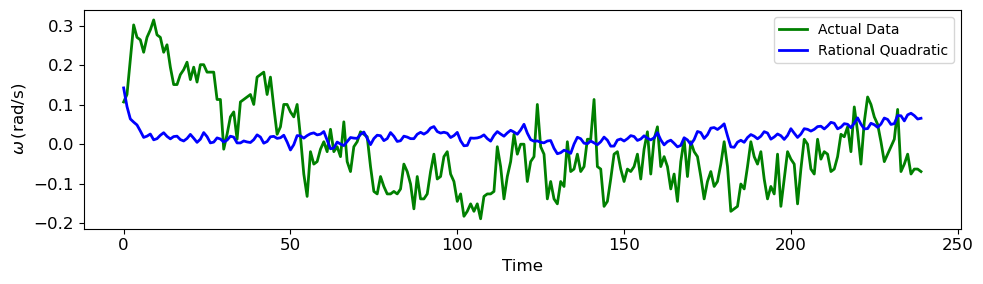

In [89]:
# the last col of feature_input is the initial frequency value. We want to create 24 hour forecast, so please use the last value of mu_rational_quadratic (final predicted value of an hour) to replace the last 

# 24 hours forecast
# prediction_24_hours = []
position = day_ahead_features_test.index.get_loc('2019-09-05 05:00:00')
len_outputs = outputs_test_angular_frequency.shape[1]
feature_input = inputs_test[position, :].reshape(1, 14)
true_output = outputs_test_angular_frequency[position, :].reshape(len_outputs, 1)
prediction_rational_quadratic = model_rational_quadratic.predict(feature_input)
mu_rational_quadratic = np.array(2 * np.pi * prediction_rational_quadratic[0, :N].reshape(N, 1)).ravel()
sigma2_rational_quadratic = np.array(
    (2 * np.pi) ** 2 * tf.math.sigmoid(prediction_rational_quadratic[0, N:]).numpy().ravel() * covariance_matrix_rq
)
ending_freq = (mu_rational_quadratic[-1] / (2 * np.pi)) + 50.0

mu_rational_quadratic_24_hours = []
mu_rational_quadratic_24_hours.append(mu_rational_quadratic)
sigma2_rational_quadratic_24_hours = []
sigma2_rational_quadratic_24_hours.append(sigma2_rational_quadratic)
true_output_24_hours = []
true_output_24_hours.append(true_output)
# for i in range(2):
#     # Next hour prediction
#     position += 1
#     feature_input = inputs_test[position, :].reshape(1, 14)
#     feature_input[0][-1] = ending_freq  # Replace the last value of feature_input with the final predicted value of an hour
#     true_output = outputs_test_angular_frequency[position, :].reshape(len_outputs, 1)
#     true_output_24_hours.append(true_output)
#     prediction_rational_quadratic = model_rational_quadratic.predict(feature_input)
#     mu_rational_quadratic = np.array(2 * np.pi * prediction_rational_quadratic[0, :N].reshape(N, 1)).ravel()
#     mu_rational_quadratic_24_hours.append(mu_rational_quadratic)
#     sigma2_rational_quadratic = np.array(
#         (2 * np.pi) ** 2 * tf.math.sigmoid(prediction_rational_quadratic[0, N:]).numpy().ravel() * covariance_matrix_rq
#     )
#     sigma2_rational_quadratic_24_hours.append(sigma2_rational_quadratic)
#     ending_freq = (mu_rational_quadratic[-1] / (2 * np.pi)) + 50.0

# Combine forecasts
mu_rational_quadratic_24_hours = np.array(mu_rational_quadratic_24_hours).flatten()
sigma2_rational_quadratic_24_hours = np.array(sigma2_rational_quadratic_24_hours).flatten()
true_output_24_hours = np.array(true_output_24_hours).flatten()

# Plot 24 hours forecast in the same plot
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(np.arange(len(true_output_24_hours)), true_output_24_hours, label='Actual Data', color='green', linewidth=2)
ax.plot(np.arange(len(mu_rational_quadratic_24_hours)), mu_rational_quadratic_24_hours, label='Rational Quadratic', color='blue', linewidth=2)

ax.set_xlabel('Time')
ax.set_ylabel(r'$\omega\, (\text{rad/s})$')
plt.legend()
plt.tight_layout()
plt.show()




# prediction_exponentiated_quadratic = model_exponentiated_quadratic.predict(feature_input)
# mu_exponentiated_quadratic = np.array(2 * np.pi * prediction_exponentiated_quadratic[0, :N].reshape(N, 1)).ravel()
# sigma2_exponentiated_quadratic = np.array(
#     (2 * np.pi) ** 2 * tf.math.sigmoid(prediction_exponentiated_quadratic[0, N:]).numpy().ravel() * covariance_matrix_eq
# )


In [82]:
mu_rational_quadratic_24_hours.shape
flattened_mu_rational_quadratic_24_hours = mu_rational_quadratic_24_hours.flatten()

In [84]:
mu_rational_quadratic_24_hours

array([[0.14231566, 0.09530107, 0.06398531, ..., 0.07234263, 0.06369009,
        0.06554528],
       [0.5836302 , 0.5213312 , 0.5119538 , ..., 0.27754408, 0.2388464 ,
        0.18970627],
       [0.5831313 , 0.5204419 , 0.51068604, ..., 0.2785058 , 0.2385432 ,
        0.1889412 ],
       ...,
       [0.58472544, 0.51846594, 0.5053133 , ..., 0.2847793 , 0.24103409,
        0.18835054],
       [0.58479244, 0.5186558 , 0.5057251 , ..., 0.2846781 , 0.24108757,
        0.18831553],
       [0.5843058 , 0.5188019 , 0.5064467 , ..., 0.28335822, 0.24056177,
        0.18838973]], dtype=float32)

In [83]:
flattened_mu_rational_quadratic_24_hours

array([0.14231566, 0.09530107, 0.06398531, ..., 0.28335822, 0.24056177,
       0.18838973], dtype=float32)